# Analyzing an initial dataset

In this notebook, we will quickly explore a real dataset of questions from writers.stackexchange.com. The dataset was initially sourced from the [archive](https://archive.org/details/stackexchange).

First, we will load the data. If you are loading a different csv, make sure you have pre-processed the raw xml using the `ml_editor` python package.

In [1]:
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.read_csv(Path('../data/writers.csv'))

## Data format

Let's start by thinking through how we would like to format the data. Amongst other decisions, we will need to decide which label we should give our model.

We want a model that measures the quality of a question. To that end, we could use:
- The number of upvotes a question gets
- The number of answers a question gets, or whether they get an answer at all
- Whether an answer was marked as accepted or not

First, let's format our dataset to reconcile questions and associated answers, and verify that they match up.

We will start by filling missing values, as well as adding two features (`text_len` and `is_question`) we will use later.

In [2]:
# Start by changing types to make processing easier
df["AnswerCount"] = df["AnswerCount"].fillna(-1)
df["AnswerCount"] = df["AnswerCount"].astype(int)
df["PostTypeId"] = df["PostTypeId"].astype(int)
df["Id"] = df["Id"].astype(int)
df.set_index("Id", inplace=True, drop=False)

# Add measure of the length of a post
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")
df["text_len"] = df["full_text"].str.len()

# A question is a post of id 1
df["is_question"] = df["PostTypeId"] == 1

## Data quality

Let's examine the quality of the data in this dataset, starting by answering the questions below

- How much of the data is missing?
- What is the quality of the text?
- Do the answers match the questions?

In [3]:
# Start by displaying columns and counts of non-null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34330 entries, 1 to 42885
Data columns (total 26 columns):
Unnamed: 0               34330 non-null int64
AcceptedAnswerId         4124 non-null float64
AnswerCount              34330 non-null int64
Body                     34256 non-null object
ClosedDate               969 non-null object
CommentCount             34330 non-null int64
CommunityOwnedDate       186 non-null object
CreationDate             34330 non-null object
FavoriteCount            3307 non-null float64
Id                       34330 non-null int64
LastActivityDate         34330 non-null object
LastEditDate             11201 non-null object
LastEditorDisplayName    614 non-null object
LastEditorUserId         10648 non-null float64
OwnerDisplayName         1976 non-null object
OwnerUserId              32792 non-null float64
ParentId                 25679 non-null float64
PostTypeId               34330 non-null int64
Score                    34330 non-null int64
Tags    

We have a little over 34.000 posts which consist of both questions and answers. 

Looking at the `Body` column, it appears that it is null in `34330 - 34256 = 74` rows. Let's take a look at these rows to see if we should remove them.

In [4]:
df[df["Body"].isna()]

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,full_text,text_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
2145,1959,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:49:56.600,NaN,2145,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2147,1961,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:51:05.897,NaN,2147,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2215,2029,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:35:10.353,NaN,2215,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2218,2032,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:41:38.677,NaN,2218,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2225,2039,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:58:59.833,NaN,2225,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2227,2041,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:05:07.753,NaN,2227,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2233,2047,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:22:44.603,NaN,2233,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2238,2052,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:38:42.200,NaN,2238,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
3138,2850,NaN,-1,NaN,NaN,0,NaN,2011-06-19T20:18:13.253,NaN,3138,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False


All of the null bodys are of  PostTypeId 4 or 5. 

The readme file that accompanied the archive only mentions PostTypeIds of 1 (questions) and 2 (answers). We will remove all rows not marked `PostTypeId` 1 or 2, since we are only interested in questions and answers.

In [5]:
df = df[df["PostTypeId"].isin([1,2])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33650 entries, 1 to 42885
Data columns (total 26 columns):
Unnamed: 0               33650 non-null int64
AcceptedAnswerId         4124 non-null float64
AnswerCount              33650 non-null int64
Body                     33650 non-null object
ClosedDate               969 non-null object
CommentCount             33650 non-null int64
CommunityOwnedDate       186 non-null object
CreationDate             33650 non-null object
FavoriteCount            3307 non-null float64
Id                       33650 non-null int64
LastActivityDate         33650 non-null object
LastEditDate             10521 non-null object
LastEditorDisplayName    606 non-null object
LastEditorUserId         9975 non-null float64
OwnerDisplayName         1971 non-null object
OwnerUserId              32117 non-null float64
ParentId                 25679 non-null float64
PostTypeId               33650 non-null int64
Score                    33650 non-null int64
Tags     

Now let's look at a few questions and answers and verify that they match, and that the text is readable.

In [6]:
questions_with_accepted_answers = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
q_and_a = questions_with_accepted_answers.join(df[["body_text"]], on="AcceptedAnswerId", how="left", rsuffix="_answer")

# Setting this option allows us to display all the data
pd.options.display.max_colwidth = 500
q_and_a[["body_text", "body_text_answer"]][:3]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."


So far so good, the **questions and answers seem to match**, and the text seems coherent and human readable  except for unescaped newlines characters ("\n").

Let's add to each row representing an answer information about the question it was answering.

In [7]:
df = df.join(df[["Id", "Title", "body_text", "text_len", "Score", "AcceptedAnswerId"]], on="ParentId", how="left", rsuffix='_question')

This allows us to see all answers for a given question like so

In [8]:
df[df["Id_question"] ==1].head()

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,body_text,full_text,text_len,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
8,5,NaN,-1,"<p>BeginningWriters.com has some good articles for beginning writers.</p>\n\n<p><a href=""http://beginningwriters.com/"">http://beginningwriters.com/</a></p>\n",NaN,0,NaN,2010-11-18T20:45:45.533,NaN,8,...,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,97,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
15,10,NaN,-1,"<p>When I'm thinking about where I learned most how to write, I think that <em>reading</em> was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I ...",NaN,3,NaN,2010-11-18T20:50:16.683,NaN,15,...,"When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re...","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when r...",962,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
79,65,NaN,-1,"<p>I particularly like <a href=""http://www.advancedfictionwriting.com/art/snowflake.php"" rel=""nofollow"" rel=""nofollow"">The Snowflake Method</a> and most of what Randy writes, including his book.</p>\n",NaN,0,NaN,2010-11-18T23:19:33.157,NaN,79,...,"I particularly like The Snowflake Method and most of what Randy writes, including his book.\n","I particularly like The Snowflake Method and most of what Randy writes, including his book.\n",93,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
123,106,NaN,-1,"<p>Reading a lot and loving to read are most important of course, but have you tried writing

## Data quantity and distribution

Now that we have linked questions and answers, and verified data quality, let's produce some summary statistics.

- How many questions are in the dataset?
- How many questions received answers?
- How long do questions tend to be?

In [9]:
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
received_answers = df[df["is_question"] & (df["AnswerCount"]!=0)]
no_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]==0)]

print("%s total questions \n %s  received at least one answer \n %s received an accepted answer" % (
    len(df[df["is_question"]]),
    len(received_answers),
    len(has_accepted_answer)))

7971 total questions 
 7827  received at least one answer 
 4124 received an accepted answer


Most questions have an answer, and only half of those answers have been accepted. Whether a question received an accepted answer could be a good label.

Another potential label would be the number of upvotes a question received, denoted in the `Score` column. This label is helpful because we can either treat it as a binary (whether the score is higher or lower than the median) or continuous depending on how granular we would like our model to be.I've plotted the score distribution below.

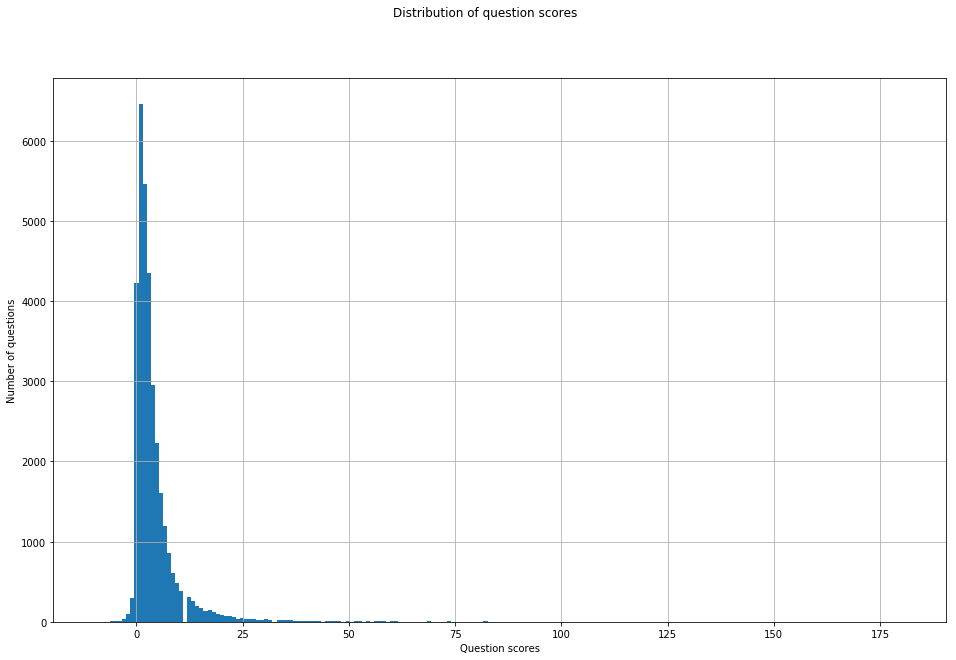

In [10]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of question scores")
plt.xlabel("Question scores")
plt.ylabel("Number of questions")
df["Score"].hist(bins=200);

Let's dive more into the questions by looking at potential predictive features, such as question length. How long are the questions in our dataset?

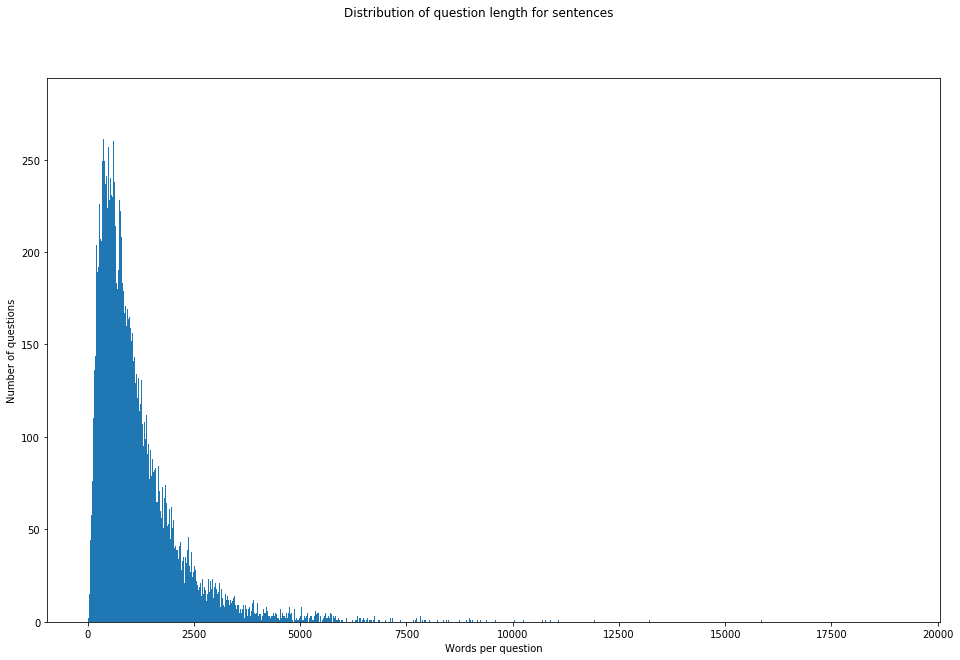

In [11]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of question length for sentences")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len = plt.hist(df["text_len"],  bins=2000,log=False)

Only a few outliers seem to contain more than two thousand words. Let's zoom in to the shorter questions on the graph.

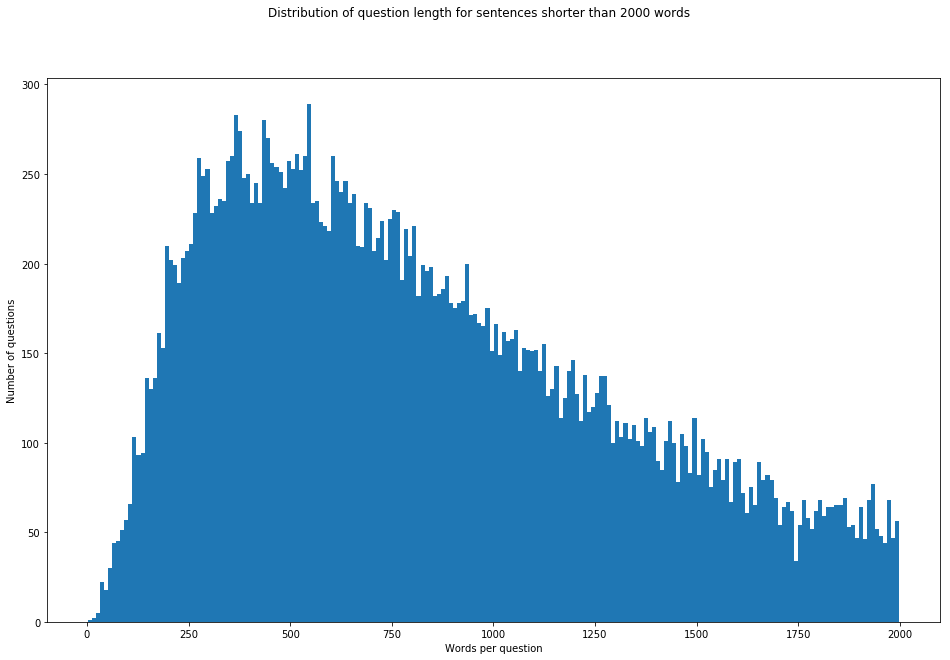

In [12]:
fig = plt.figure(figsize=(16,10))
fig.suptitle(
    "Distribution of question length for sentences shorter than 2000 words")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len_trunc = plt.hist(df[df["text_len"]<2000]["text_len"], bins=200, log=False)

Now is sentence length predictive of getting many upvotes? 

In order to start answering this question, we can update this plot to overlay the distributions for both high and low score questions.

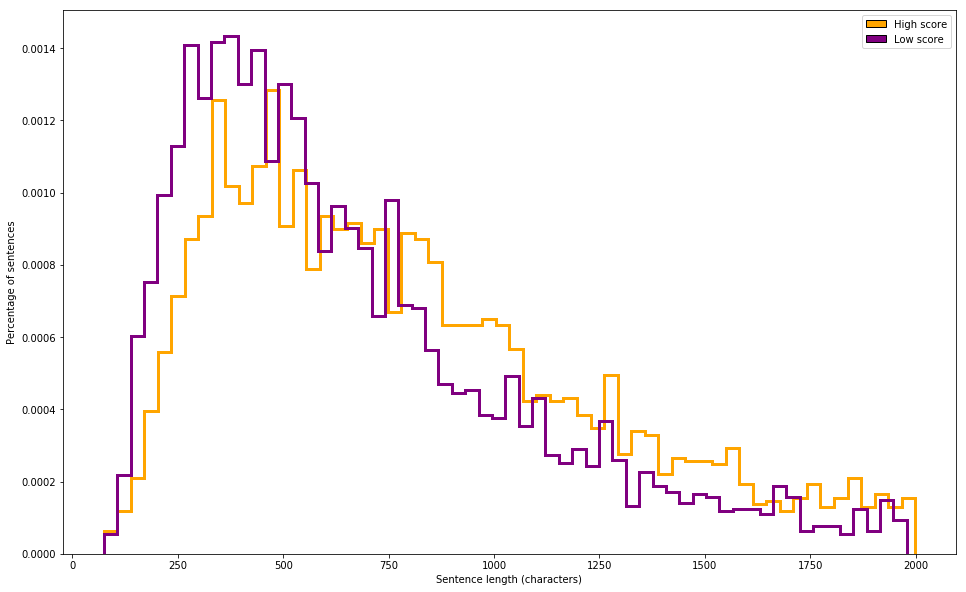

In [13]:
high_score = df["Score"] > df["Score"].median()
# We filter out really long questions
normal_length = df["text_len"] < 2000

ax = df[df["is_question"] & high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="orange",
    linewidth=3,
    grid=False,
    figsize=(16, 10),
)

df[df["is_question"] & ~high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="purple",
    linewidth=3,
    grid=False,
)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ["orange", "purple"]
]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (characters)")
ax.set_ylabel("Percentage of sentences");

It seems that there may be a relatively higher proportion of very short questions amongst unanswered ones. Questions with high scores tend to be longer on average. This makes question length a feature candidate that we should try for our model.

Going back to using "received answers" as a measure of quality, let's look at the number of answers questions get, and more precisely the distribution of the quantity of answers.

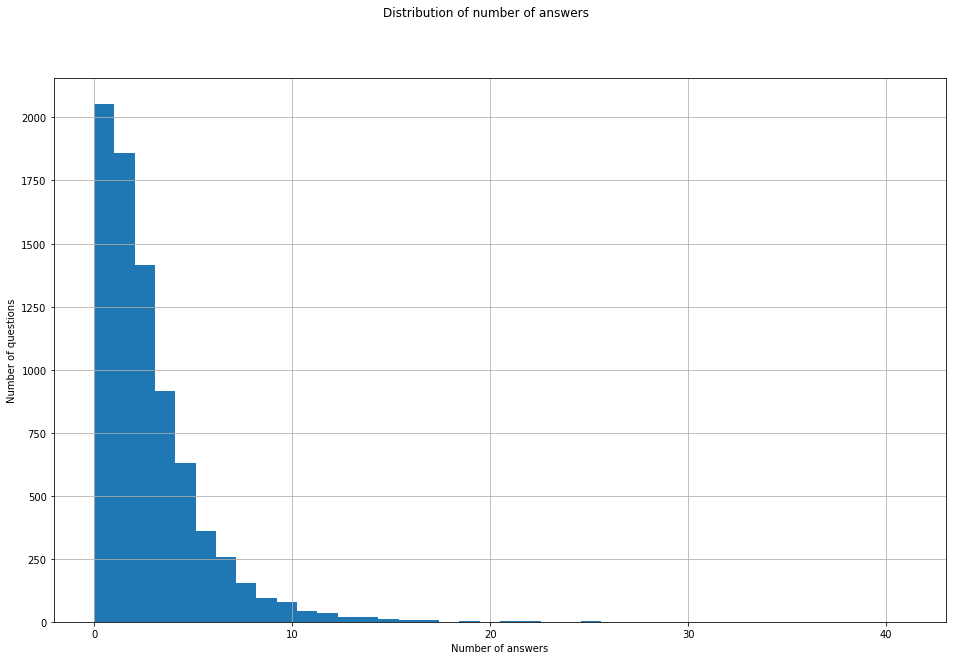

In [14]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of number of answers")
plt.xlabel("Number of answers")
plt.ylabel("Number of questions")
hist = df[df["is_question"]]["AnswerCount"].hist(bins=40)

Let's see if questions with high scores tend to get more answers. 

First, let's plot one as a function of the other, and see whether we can establish a trend.

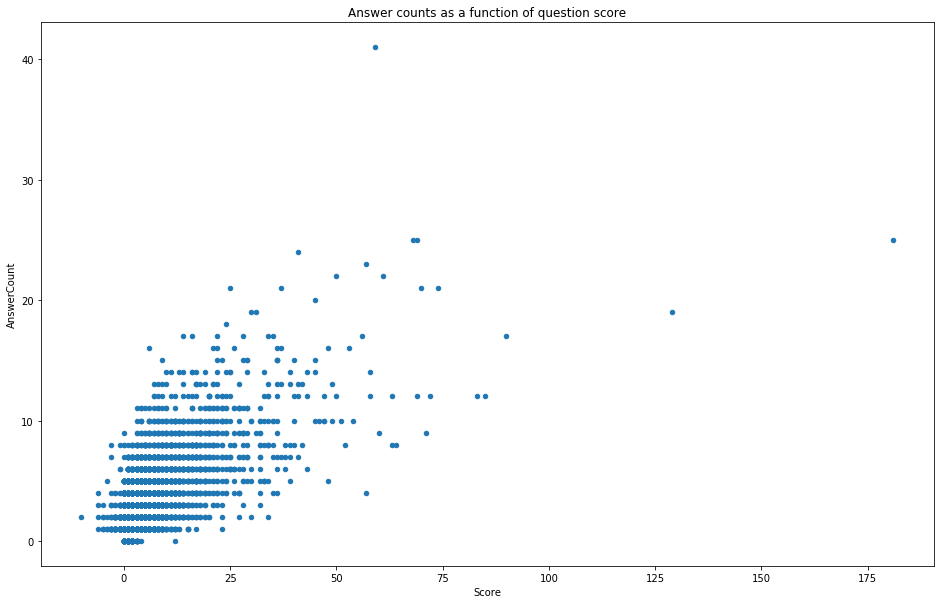

In [15]:
scatter = df[df["is_question"]][["Score", "AnswerCount"]].plot(x="Score", y="AnswerCount", 
                                                               kind="scatter",
                                                              figsize=(16, 10))
ax.set_xlabel("Score")
ax.set_ylabel("Num answers")
scatter.set_title("Answer counts as a function of question score");

Scores and number of answers seem correlated. We mentioned above making the score into a binary label by using `is_score_above_median` as the label. Let's see how this label would correlate with the number of answers by plotting histograms of the numbers of answers a question gets for question in each category (score above and below the median)

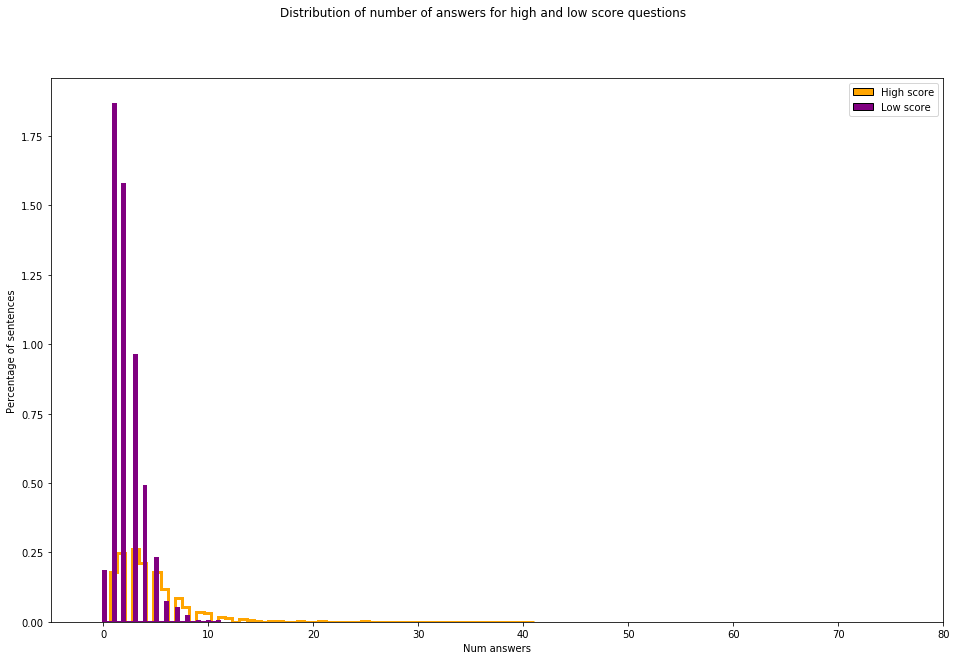

In [16]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of number of answers for high and low score questions")
plt.xlim(-5,80)

ax = df[df["is_question"] &
        (df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                          density=True,
                                                          histtype="step",
                                                          color="orange",
                                                          linewidth=3,
                                                          grid=False,
                                                          figsize=(16, 10))

df[df["is_question"] &
   ~(df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                     density=True,
                                                     histtype="step",
                                                     color="purple",
                                                     linewidth=3,
                                                     grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
           ["orange", "purple"]]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Num answers")
ax.set_ylabel("Percentage of sentences");

It seems like questions that get a high score get more answers. The score of a question thus seems like a good initial label since it is more granular, but the number of answers would be a fine choice as well. 

While it would make a good label, we cannot use the number of answers as a feature. This is because despite being correlated with the score, as the plot above shows, we will not have access to it at inference time, when we receive input from the users.

Since our model needs to work without having access to this input, we can either ignore it completely during training, or use it as a feature during training, and set the value of this feature as a constant in production. The first approach is simpler, but the second approach can help a model separate the effect of the "number of answers" feature from other style effects which we do want to capture. I'll let the reader experiment with both approaches.

After this summary exploration, we will see how to [split data](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/splitting_data.ipynb).